In [1]:
import torch

name= 'investigate_symmetry_finegrained'
seed= 17
device= 'mps'
binarize= True
P = 600
P_eval = 300
C = 10

# Network and Relaxation
N= 100
H= 300
num_layers= 1
J_D= 0.0
max_steps= 10                                   # full sweeps over the network (relaxation)
init_mode= "zeros"                             # "input", "zeros", "noisy_zeros"
init_noise= 0.0
lambda_left= [0.0, 1.0]     # first is lambda_x, last affects the readout layer
lambda_right= [0.5, 1000.0]  # last is lambda_y, last but one affects the readout layer
# lambda_x= 0.0
# lambda_y= 1000.0
# lambda_l= 2.0
# lambda_r= 2.0

lambda_wback_skip= [0.0]
lambda_input_skip= [1.0]
lambda_input_output_skip= 0.0  # multiplied by L
lambda_wforth_skip= [0.0]

lr_wforth_skip= 0.0
weight_decay_wforth_skip= 0.000
lr_input_skip= 0.1
weight_decay_input_skip= 0.000
lr_input_output_skip= 0.0
weight_decay_input_output_skip= 0.000

fc_left= False
fc_right= False
fc_input= False
lambda_internal= 1.0
lambda_fc= 1.0
symmetric_W= False
symmetric_J_init= True
double_dynamics= False
double_update= False
use_local_ce= False
beta_ce= 10.0
lambda_cylinder= None

# Perceptron Rule
num_epochs= 70
batch_size= 16
lr_J= 0.03
lr_W= 0.1
threshold_hidden= 1.0
threshold_readout= 4.0
weight_decay_J= 0.005
weight_decay_W= 0.005

begin_curriculum= 1.0  # in [0,1). if >= 1, no curriculum
p_curriculum= 0.5

# Evaluation
eval_interval= 1  # epochs
skip_representations= False
skip_couplings= False
skip_fields= False

# Assemble the pieces
lr = [lr_J] * num_layers + [lr_W] * 2
weight_decay = [weight_decay_J] * num_layers + [weight_decay_W] * 2
threshold = [threshold_hidden] * num_layers + [threshold_readout]

In [2]:
from src.data import prepare_mnist

train_inputs, train_targets, eval_inputs, eval_targets, projection_matrix = (
    prepare_mnist(
        P * C,
        P_eval * C,
        N,
        binarize,
        seed,
        shuffle=True,
    )
)
train_inputs = train_inputs.to(device)
train_targets = train_targets.to(device)
eval_inputs = eval_inputs.to(device)
eval_targets = eval_targets.to(device)

In [3]:
import os

from src.batch_me_if_u_can import BatchMeIfUCan
from src.handler import Handler

output_dir = name
os.makedirs(output_dir, exist_ok=True)

model_kwargs = {
    "num_layers": num_layers,
    "N": N,
    "C": C,
    "lambda_left": lambda_left,
    "lambda_right": lambda_right,
    "lambda_internal": lambda_internal,
    "J_D": J_D,
    "device": device,
    "seed": seed,
    "lr": torch.tensor(lr),
    "threshold": torch.tensor(threshold),
    "weight_decay": torch.tensor(weight_decay),
    "init_mode": init_mode,
    "init_noise": init_noise,
    "symmetric_W": symmetric_W,
    "symmetric_J_init": symmetric_J_init,
    "double_dynamics": double_dynamics,
    "double_update": double_update,
    "use_local_ce": use_local_ce,
    "beta_ce": beta_ce,
    "fc_left": fc_left,
    "fc_right": fc_right,
    "fc_input": fc_input,
    "lambda_fc": lambda_fc,
    "lambda_cylinder": lambda_cylinder,
    "lambda_wback_skip": lambda_wback_skip,
    "lambda_wforth_skip": lambda_wforth_skip,
    "lr_wforth_skip": lr_wforth_skip,
    "weight_decay_wforth_skip": weight_decay_wforth_skip,
    "lambda_input_skip": lambda_input_skip,
    "lambda_input_output_skip": lambda_input_output_skip,
    "lr_input_skip": lr_input_skip,
    "weight_decay_input_skip": weight_decay_input_skip,
    "lr_input_output_skip": lr_input_output_skip,
    "weight_decay_input_output_skip": weight_decay_input_output_skip,
    "H": H,
}
model_cls = BatchMeIfUCan  # noqa: F821
model = model_cls(**model_kwargs)
handler = Handler(
    model,
    init_mode,
    skip_representations,
    skip_couplings,
    name,
)

In [5]:
idxs = torch.randint(0, len(train_inputs), (16,)).tolist()
x = train_inputs[idxs]
y = train_targets[idxs]

## No learning

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
max_sweeps = 50

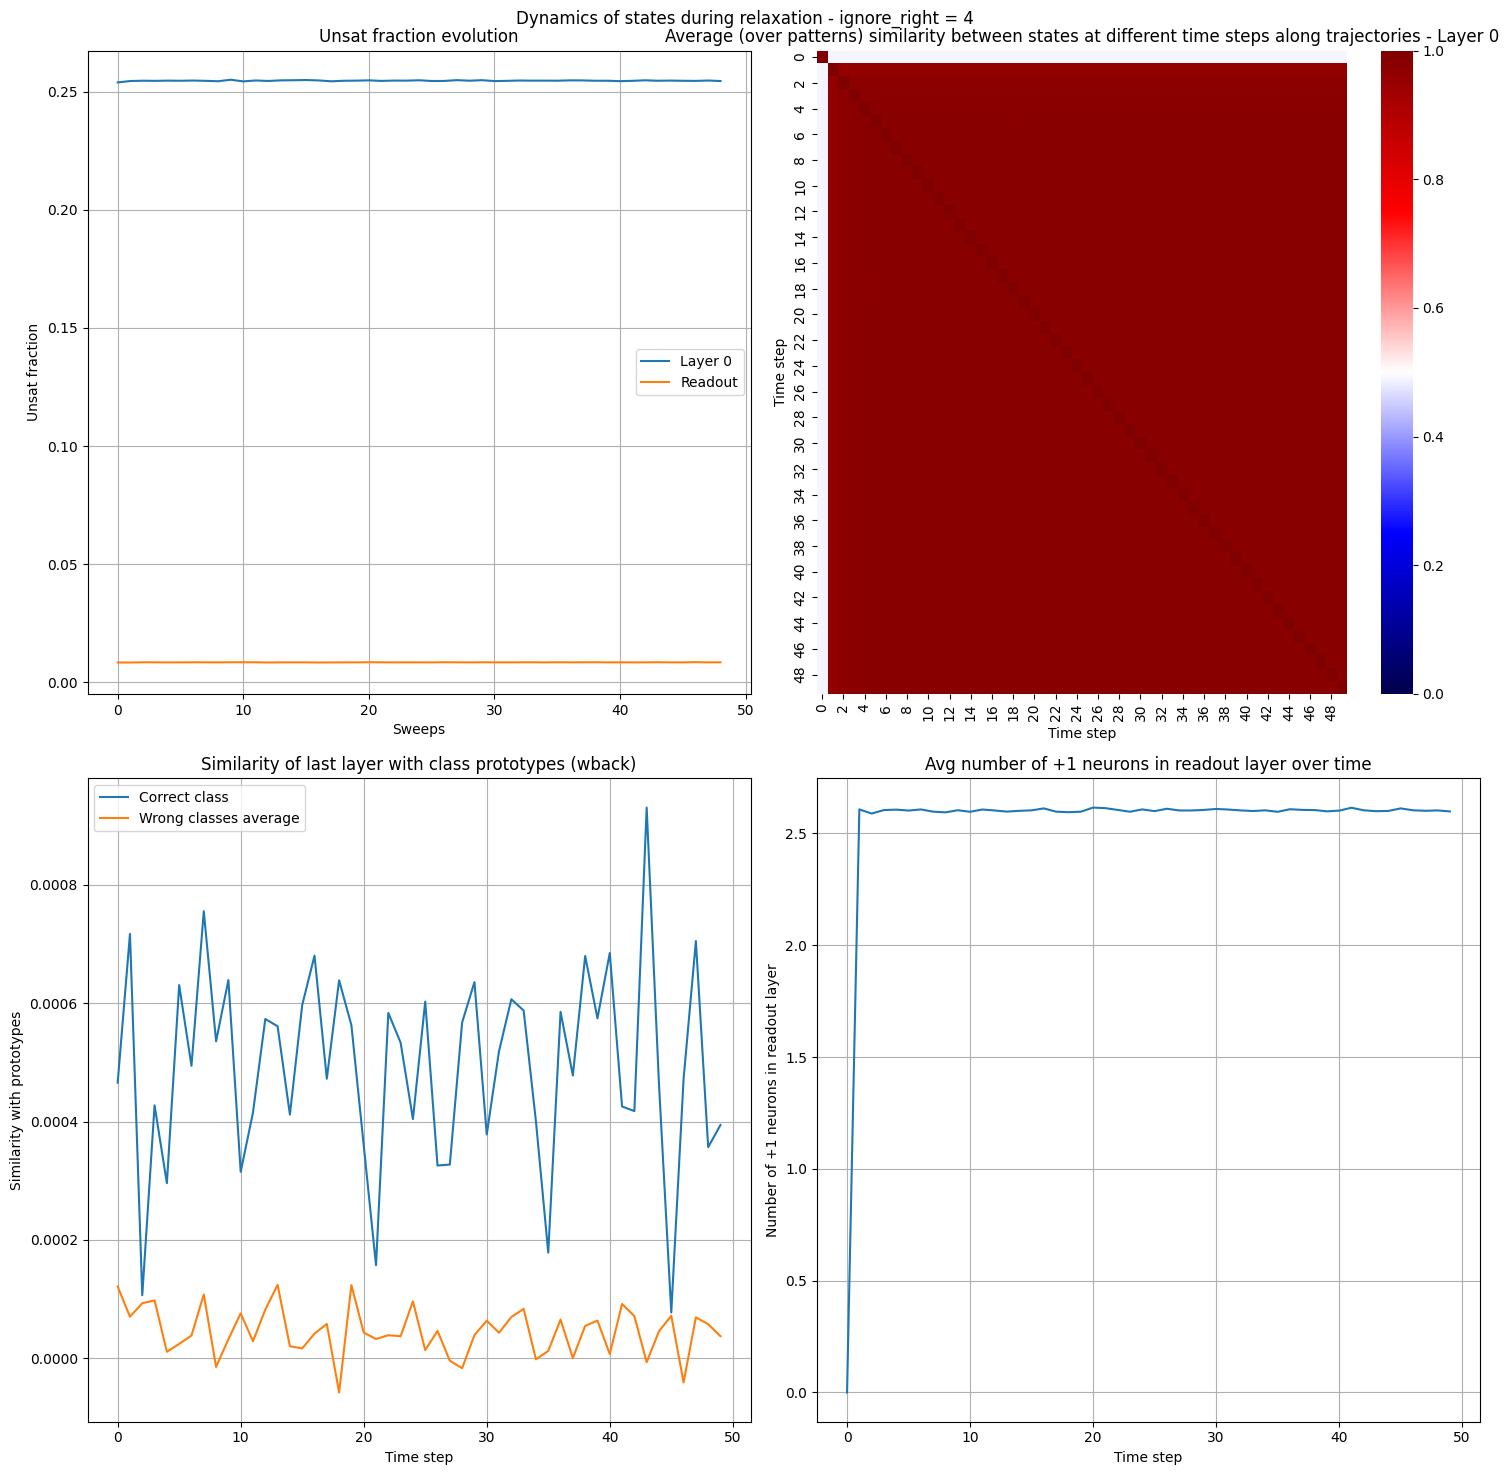

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15), sharey=False)


ignore_right = 4
states, unsats = handler.relaxation_trajectory(
    train_inputs, train_targets, max_sweeps, ignore_right=ignore_right
)
# unsat evolution
unsat_evolution = unsats[:, 1:, :, :].mean(dim=(0, -1), dtype=torch.float32).cpu()
ax = axs[0, 0]
for l in range(num_layers + 1):
    ax.plot(unsat_evolution[:, l], label=f"Layer {l}" if l < num_layers else "Readout")
ax.set_xlabel("Sweeps")
ax.set_ylabel("Unsat fraction")
ax.set_title("Unsat fraction evolution")
ax.grid()
ax.legend()
ax.set_ylim(-0.005)
# heatmap of similarities between different timesteps' states
B, T, L, H = states.shape
similarities = torch.zeros((L, T, T))
for t1 in range(T):
    for t2 in range(T):
        sims = (states[:, t1, 1:-2, :] == states[:, t2, 1:-2, :]).mean(
            dim=(0, -1), dtype=torch.float32
        )  # (L,). exclude readout
        similarities[:, t1, t2] = sims.cpu()
ax = axs[0, 1]
l = 1
sns.heatmap(
    similarities[l, :, :],
    ax=ax,
    cmap="seismic",
    vmin=0,
    vmax=1,
    label=f"Layer {l}" if l < num_layers else "Readout",
)
ax.set_xlabel("Time step")
ax.set_ylabel("Time step")
ax.set_title(
    "Average (over patterns) similarity between states at different time steps along trajectories - Layer 0"
)
# similarity with class prototypes (columns of W_back)
ax = axs[1, 0]
similarities = torch.zeros((2, T))
for t in range(T):
    labels = train_targets.argmax(dim=1)
    sims_correct = torch.nn.functional.cosine_similarity(
        states[:, t, -3, :], model.W_back[:, labels].T, dim=-1
    ).mean(dim=0, dtype=torch.float32)
    similarities[0, t] = sims_correct

    sims_wrong = []
    for shift in range(1, C):
        labels_shifted = (labels + shift) % C
        sims_shifted = torch.nn.functional.cosine_similarity(
            states[:, t, -3, :], model.W_back[:, labels_shifted].T, dim=-1
        ).mean(dim=0, dtype=torch.float32)
        sims_wrong.append(sims_shifted)
    similarities[1, t] = torch.mean(torch.stack(sims_wrong), dim=0)
ax.plot(similarities[0, :], label="Correct class")
ax.plot(similarities[1, :], label="Wrong classes average")
ax.set_xlabel("Time step")
ax.set_ylabel("Similarity with prototypes")
ax.set_title("Similarity of last layer with class prototypes (wback)")
ax.grid()
ax.legend()
# number of +1 neurons in readout layer
ax = axs[1, 1]
number_ones_readout = (
    (states[:, :, -2, :C] == 1).sum(dim=-1).mean(dim=0, dtype=torch.float32).cpu()
)  # (T,)
ax.plot(number_ones_readout)
ax.set_xlabel("Time step")
ax.set_ylabel("Number of +1 neurons in readout layer")
ax.set_title("Avg number of +1 neurons in readout layer over time")
ax.grid()

fig.suptitle(f"Dynamics of states during relaxation - ignore_right = {ignore_right}")
plt.tight_layout()
plt.show()